# Diagnóstico de Nuemonia utilizando redes neuronales.

### Residual Neural Network

Fundación Fulgor.

Axel Aguerreberry.

In [1]:
import tensorflow as tf
import timeit

In [27]:
import numpy as np

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
import matplotlib.pyplot as plt

In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [6]:
import tensornets as nets

In [7]:
import matplotlib.pyplot as plt

In [21]:
import random
from sklearn.utils import shuffle
import math

In [9]:
import tensornets as nets

In [10]:
import keras

Using TensorFlow backend.


In [11]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("/home/axel/DATASETS/chest_xray"))

['test', 'train', 'val', '.DS_Store']


In [12]:
print(os.listdir("/home/axel/DATASETS/chest_xray/train/"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [13]:
TRAIN_DIR = "/home/axel/DATASETS/chest_xray/train/"
TEST_DIR =  "/home/axel/DATASETS/chest_xray/test/"

**Obtención de Imágenes y Labels.**

In [14]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [15]:
%%time
X_train, y_train = get_data(TRAIN_DIR)
X_test , y_test = get_data(TEST_DIR)

  0%|          | 0/1342 [00:00<?, ?it/s]/home/axel/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 390/390 [00:09<00:00, 41.47it/s]


CPU times: user 5min 54s, sys: 7min, total: 12min 54s
Wall time: 4min 41s


In [16]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5216, 150, 150, 3) (5216, 2)
(624, 150, 150, 3) (624, 2)


In [22]:
def random_mini_batches(X, Y, mini_batch_size, seed, num_examples):

    np.random.seed(seed)           
    m = num_examples       
    mini_batches = []
        
    
    shuffled_X, shuffled_Y = shuffle(X, Y, random_state=0)

    
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size, :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    if m % mini_batch_size != 0:
        
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        num_complete_minibatches += 1
    
    return mini_batches, num_complete_minibatches

In [23]:
def reshape_images(images_test):
    
    
    newImages = []

    for image in images_test:
            newImage = skimage.transform.resize(image, (128, 128, 3), mode="constant")
            newImages.append(newImage)
    
    return(np.asarray(newImages))

In [24]:
np.random.seed(123)           
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [25]:
X_train_1 = X_train[:, :, :, :]
y_train_1 = y_train[:, :]

X_test_1 = X_test[:, :, :, :]
y_test_1 = y_test[:, :]


In [26]:
X_train_1 = reshape_images(X_train_1)
X_test_1 = reshape_images(X_test_1)

In [27]:
print(X_train_1.shape, y_train_1.shape)
print(X_test_1.shape, y_test_1.shape)

(5216, 128, 128, 3) (5216, 2)
(624, 128, 128, 3) (624, 2)


In [71]:
X_train_1 = X_train_1.astype('float32')
y_train_1 = y_train_1.astype('float32')

X_test_1 = X_test_1.astype('float32')
y_test_1 = y_test_1.astype('float32')

Construcción de Red Neuronal.

In [72]:
inputs = tf.placeholder(tf.float32, [None, 128, 128, 3])
outputs = tf.placeholder(tf.float32, [None, 2])

logits = nets.ResNet50(inputs, is_training=True, classes=2)
model = tf.identity(logits, name='logits')


loss = tf.losses.softmax_cross_entropy(outputs, logits)
train = tf.train.AdamOptimizer(learning_rate=0.00001,
    beta1=0.1,
    beta2=0.999,
    epsilon=1e-05).minimize(loss)

In [73]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(outputs, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [74]:
logits.print_summary()

Scope: resnet50_6
Total layers: 54
Total weights: 748
Total parameters: 70,669,190


In [75]:
logits.print_outputs()

Scope: resnet50_6
conv1/pad:0 (?, 134, 134, 3)
conv1/conv/BiasAdd:0 (?, 64, 64, 64)
conv1/bn/FusedBatchNorm:0 (?, 64, 64, 64)
conv1/relu:0 (?, 64, 64, 64)
pool1/pad:0 (?, 66, 66, 64)
pool1/MaxPool:0 (?, 32, 32, 64)
conv2/block1/0/conv/BiasAdd:0 (?, 32, 32, 256)
conv2/block1/0/bn/FusedBatchNorm:0 (?, 32, 32, 256)
conv2/block1/1/conv/BiasAdd:0 (?, 32, 32, 64)
conv2/block1/1/bn/FusedBatchNorm:0 (?, 32, 32, 64)
conv2/block1/1/relu:0 (?, 32, 32, 64)
conv2/block1/2/conv/BiasAdd:0 (?, 32, 32, 64)
conv2/block1/2/bn/FusedBatchNorm:0 (?, 32, 32, 64)
conv2/block1/2/relu:0 (?, 32, 32, 64)
conv2/block1/3/conv/BiasAdd:0 (?, 32, 32, 256)
conv2/block1/3/bn/FusedBatchNorm:0 (?, 32, 32, 256)
conv2/block1/out:0 (?, 32, 32, 256)
conv2/block2/1/conv/BiasAdd:0 (?, 32, 32, 64)
conv2/block2/1/bn/FusedBatchNorm:0 (?, 32, 32, 64)
conv2/block2/1/relu:0 (?, 32, 32, 64)
conv2/block2/2/conv/BiasAdd:0 (?, 32, 32, 64)
conv2/block2/2/bn/FusedBatchNorm:0 (?, 32, 32, 64)
conv2/block2/2/relu:0 (?, 32, 32, 64)
conv2/block

In [76]:
mini_batch_size = 8

In [26]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    print("Inicializacion completa")
    
    sess.run(logits.pretrained())
    
    train_history = []
    test_history = []
    
    
    
    for i in range(10):      ## epochs
        
        
        batches_train, num_batches_train = random_mini_batches(X_train_1, y_train_1
                              , mini_batch_size = mini_batch_size, seed = 123, num_examples = 5216)
        
        train_accuracy = 0
        
        for k in range(num_batches_train-1): ## Loop por todos los batches
            
            alpha = batches_train[k][0]
            beta = batches_train[k][1]
        
            train.run(feed_dict={inputs: alpha, outputs: beta})
            
            train_accuracy+= accuracy.eval(feed_dict={inputs: alpha, outputs: beta})
        

        
        batches_test, num_batches_test = random_mini_batches(X_test_1,
                                                         y_test_1, 
                                                         mini_batch_size = mini_batch_size, seed = 123, num_examples = 624)
        
        
                
        test_accuracy = 0
                
        for j in range(num_batches_test-1):

              test_accuracy+= accuracy.eval(feed_dict={inputs: batches_test[j][0], outputs: batches_test[j][1]})
                    
        train_sum = (train_accuracy/num_batches_train)
        test_sum = (test_accuracy/num_batches_test)
                    
        train_history.append(train_sum)    
        test_history.append(test_sum)  
        
            
        print('step %d, training accuracy %g, test accuracy %g' % (i, train_sum, test_sum))
        
    predictions = logits.eval(feed_dict={inputs: X_test_1})
    
    accuracy = accuracy.eval(feed_dict={inputs: X_test_1, outputs: y_test_1})

Inicializacion completa
step 0, training accuracy 0.982937, test accuracy 0.839744
step 1, training accuracy 0.991948, test accuracy 0.858538
step 2, training accuracy 0.994248, test accuracy 0.862538
step 3, training accuracy 0.995399, test accuracy 0.868526
step 4, training accuracy 0.995974, test accuracy 0.870128
step 5, training accuracy 0.996357, test accuracy 0.875731
step 6, training accuracy 0.996357, test accuracy 0.882115
step 7, training accuracy 0.996357, test accuracy 0.886923
step 8, training accuracy 0.997856, test accuracy 0.887814
step 9, training accuracy 0.997856, test accuracy 0.889078


## Precisión de Clasificación

In [5]:
accuracy

0.9166667

## Matriz de Confusiones

Obtención de Softmax de útima capa.

In [60]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [61]:
new_preds = []

for i in range(300):
    alpha = softmax(predictions[i])
    
    new_preds.append(alpha)
    
new_preds = np.asarray(new_preds)    

In [65]:
y_test_1 = y_test_1.tolist()

new_test_1 = []

for i in range(624):
    
    if y_test_1[i] == [0.0, 1.0]:
        new_test_1.append(1)
    else: new_test_1.append(0)

In [66]:
new_preds = new_preds.tolist()

preds = []

for i in range(624):
    
    if new_preds[i] == [0.0, 1.0]:
        preds.append(1)
    else: preds.append(0)

In [28]:
confusion_matrix(new_test_1, preds)

array([[156,   3],
       [ 78, 387]])

## Gráficos de Entrenamiento

In [29]:
epochs = []
for i in range(10):
    epochs.append(i)
    

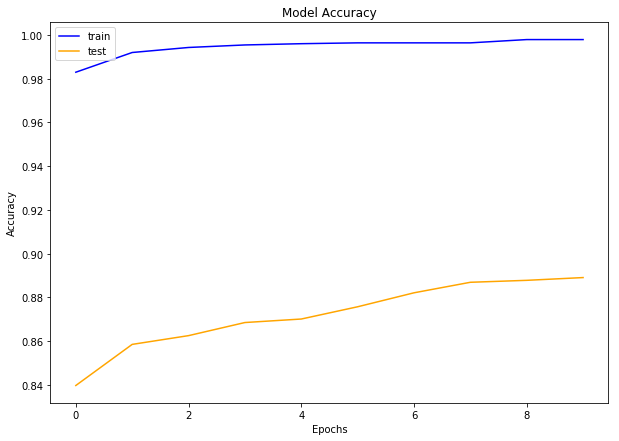

In [30]:
plt.figure(figsize=(10,7))

plt.plot(epochs, train_history, color='blue')
plt.plot(epochs, test_history, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
train_history_lost = []
for i in train_history:
    train_history_lost.append(1-i)
    
test_history_lost = []
for i in test_history:
    test_history_lost.append(1-i)

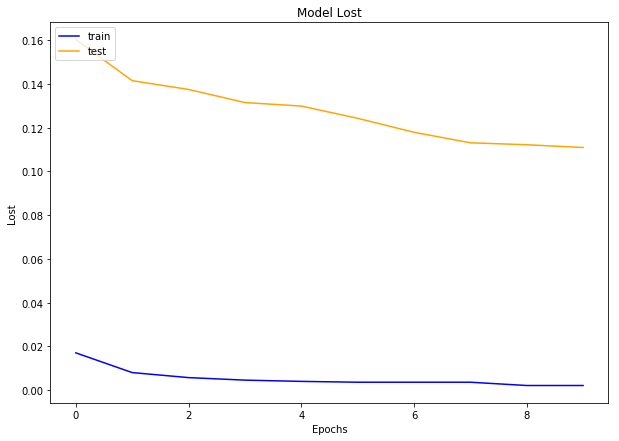

In [19]:
plt.figure(figsize=(10,7))

plt.plot(epochs, train_history_lost, color='blue')
plt.plot(epochs, test_history_lost, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Lost')
plt.title('Model Lost')
plt.legend(['train', 'test'], loc='upper left')
plt.show()